# Contexto

Você é o responsável por dados e análises no time de Relacionamento com o Cliente. Este time é responsável por cuidar dos nossos clientes, tirando todas as dúvidas e os ajudando a fazer melhor uso dos nossos produtos.

Nos últimos tempos tivemos alguns problemas e precisamos da sua ajuda para tomarmos as melhores decisões para melhor atender nossos clientes. 


### Questões

1.	Foi implementada no dia 1 de agosto uma funcionalidade nova no site do Ton que acredita que irá diminuir a quantidade de chamados recebidos. Avalie se a implementação teve um impacto estatisticamente relevante.

2.	Foi notado pelo nosso time que clientes recem credenciados possuem um comportamento específico em relação à quantidade de chamados realizados logo após seu credenciamento. Identifique e prepare alguma forma de visualizar essa diferença notada pelos agentes.

3.	Para conseguir melhorar a qualidade do nosso atendimento ao cliente, foi proposto que a alguns chamados tenham prioridade de atendimento. Levando em consideração o motivo dos chamados, como você estabeleceria essa prioridade da fila de espera? Sugestão: Proponha uma clusterização da base de clientes que julgue atender da melhor forma a necessidade apresentada.

4.	Escreva duas queries em SQL que retornem: 

i) o volume de chamados por semana dos últimos três meses para cada cluster de clientes proposto na questão 3.

ii) uma série histórica dia a dia, que para cada dia retorne o número de chamados referentes aos últimos 30 dias (por exemplo, para o dia 30/01, a query deve retornar a quantidade de chamados totais entre os dias 01/01 e 30/01)


5.	Questão de estudo livre: Como é esperado de um analista de dados, traga insights relevantes sobre pontos de atenção e possíveis melhorias que você identificou ao analisar ambas as bases de dados. Além disso faça pelo menos duas perguntas relacionadas aos dados que julgue relevantes para análise, você também pode sugerir outros dados para enriquecer os aqui disponibilizados.

### Imports

In [1]:
# Importando pacotes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sqlalchemy
from pandasql import sqldf

### Dicionário

In [2]:
dic_cases = pd.read_csv('dic_cases.csv')
dic_creds = pd.read_csv('dic_creds.csv')

In [3]:
dic_cases

,accountid,Chave primária da tabela
0,date_ref,Data do chamado
1,channelid,Canal do chamado (chat = 1; telefone = 2; e-ma...
2,waitingtime,Tempo de espera para atendimento (segundos)
3,missed,Flag de chamado atendido
4,pesquisa_de_satisfa_o__c,Flag de pesquisa de satisfação preenchida
5,assunto,Assunto do chamado
6,Id,Chave da tabela


In [4]:
dic_creds

,Coluna,Descrição
0,cred_date,Data de credenciamento
1,shipping_address_city,Endereço de entrega – cidade
2,shipping_address_state,Endereço de entrega – estado
3,max_machine,Produto adquirido
4,accountid,Chave secundária da tabela


# Análise de Dados

In [5]:
# Carregamento dos dados
df_cases = pd.read_csv('cases.csv')
df = df_cases.copy()
df_cred = pd.read_csv('creds.csv')
df2 = df_cred.copy()

In [6]:
# Visualização dos dados
df

,Unnamed: 0,accountid,date_ref,channelid,waitingtime,missed,pesquisa_de_satisfa_o__c,assunto,Id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Primeir...,0013j00002z0CeEAAU
...,...,...,...,...,...,...,...,...,...
126984,126984,0013j00002yi49FAAQ,2020-08-26,2.0,9.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Prazos ...,0013j00002yi49FAAQ
126985,126985,0013j00002yi49FAAQ,2020-09-09,2.0,4.0,False,NaN,Produto:D195:Ativação,0013j00002yi49FAAQ
126986,126986,0013j00002yi49FAAQ,2020-09-21,2.0,3.0,False,NaN,Cadastro:Recredenciamento:Dúvidas,0013j00002yi49FAAQ
126987,126987,0013j00002yi49FAAQ,2020-09-21,2.0,3.0,False,NaN,Produto:Cartão pré-pago:Dúvidas,0013j00002yi49FAAQ


In [7]:
# Visualização dos dados
df2

,Unnamed: 0,cred_date,shipping_address_city,shipping_address_state,max_machine,accountid
0,0,2020-04-18,Feira de Santana,BA,T1,NaN
1,1,2020-10-16,Bacuri,MA,T1,NaN
2,2,2020-09-01,Bernardo Sayão,TO,T1,NaN
3,3,2020-08-29,Rio de Janeiro,RJ,T3,NaN
4,4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
...,...,...,...,...,...,...
126984,126984,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126985,126985,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126986,126986,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126987,126987,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ


## Limpeza e Tratamento dos Dados

### Visualização dos Dados

In [8]:
# Primeiramente irei remover a coluna 'Unnamed: 0' de ambos datasets pois esta representa apenas o índice
df.drop(columns = 'Unnamed: 0', axis = 1, inplace= True)
df2.drop(columns = 'Unnamed: 0', axis = 1, inplace= True)

In [9]:
# Verificando o tamanho dos datasets
print(df.shape)
print(df2.shape)

(126989, 8)
(126989, 5)


In [10]:
# Informativo dos datasets
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126989 entries, 0 to 126988
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   accountid                 77489 non-null  object 
 1   date_ref                  77489 non-null  object 
 2   channelid                 77489 non-null  float64
 3   waitingtime               77489 non-null  float64
 4   missed                    77489 non-null  object 
 5   pesquisa_de_satisfa_o__c  11585 non-null  object 
 6   assunto                   77489 non-null  object 
 7   Id                        77489 non-null  object 
dtypes: float64(2), object(6)
memory usage: 7.8+ MB


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126989 entries, 0 to 126988
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   cred_date               126989 non-null  object
 1   shipping_address_city   126989 non-null  object
 2   shipping_address_state  126989 non-null  object
 3   max_machine             126989 non-null  object
 4   accountid               77489 non-null   object
dtypes: object(5)
memory usage: 4.8+ MB


In [12]:
# Renomeando as colunas
df.columns = ['id_conta','data','canal','tempo_espera','chamada_perdida','pesquisa_satisfacao','assunto','id']

In [13]:
# Renomeando as colunas
df2.columns = ['data_cred', 'endereco_entrega_cidade', 'endereco_entrega_estado', 'produto_adquirido', 'id_conta']

### Valores NaN

In [14]:
# Verificando os valores NaN
df.isna().sum()

id_conta                49500
data                    49500
canal                   49500
tempo_espera            49500
chamada_perdida         49500
pesquisa_satisfacao    115404
assunto                 49500
id                      49500
dtype: int64

In [15]:
df2.isna().sum()

data_cred                      0
endereco_entrega_cidade        0
endereco_entrega_estado        0
produto_adquirido              0
id_conta                   49500
dtype: int64

In [16]:
# Remover os registros onde todos os valores são NaN
df.dropna(axis = 0, how = 'all', inplace= True)
df.isna().sum()

id_conta                   0
data                       0
canal                      0
tempo_espera               0
chamada_perdida            0
pesquisa_satisfacao    65904
assunto                    0
id                         0
dtype: int64

In [17]:
# Visualizando os registros que temos valores NaN na variável 'pesquisa_satisfacao'
df[(df['pesquisa_satisfacao'].isna())]

,id_conta,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Primeir...,0013j00002z0CeEAAU
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Produto:S920:Ativação,0013j00002z0CeEAAU
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,False,NaN,Produto:Cartão pré-pago:Dúvidas,0013j00002z0CeEAAU
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,NaN,Logística:Envio de Cartão:Tracking,0013j00002zQgldAAC
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,NaN,Pedido:Cancelamento:Outros,0013j00002zQgldAAC
...,...,...,...,...,...,...,...,...
126984,0013j00002yi49FAAQ,2020-08-26,2.0,9.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Prazos ...,0013j00002yi49FAAQ
126985,0013j00002yi49FAAQ,2020-09-09,2.0,4.0,False,NaN,Produto:D195:Ativação,0013j00002yi49FAAQ
126986,0013j00002yi49FAAQ,2020-09-21,2.0,3.0,False,NaN,Cadastro:Recredenciamento:Dúvidas,0013j00002yi49FAAQ
126987,0013j00002yi49FAAQ,2020-09-21,2.0,3.0,False,NaN,Produto:Cartão pré-pago:Dúvidas,0013j00002yi49FAAQ


In [18]:
# Verificando os valores que temos na variável 'pesquisa_satisfacao'
df[(df['pesquisa_satisfacao'].isna() == False)]['pesquisa_satisfacao'].value_counts()

Enviado        9996
Incrivel        899
Bom             425
Normal          112
NaoResolveu     107
Feliz            19
MalAtendido      16
Triste            6
Pessimo           3
Cansativo         2
Name: pesquisa_satisfacao, dtype: int64

In [19]:
# Vamos imputar o valor 'Sem_resposta'
df['pesquisa_satisfacao'] = df['pesquisa_satisfacao'].fillna('Sem_resposta')

In [20]:
df2

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
0,2020-04-18,Feira de Santana,BA,T1,NaN
1,2020-10-16,Bacuri,MA,T1,NaN
2,2020-09-01,Bernardo Sayão,TO,T1,NaN
3,2020-08-29,Rio de Janeiro,RJ,T3,NaN
4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
...,...,...,...,...,...
126984,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126985,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126986,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126987,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ


In [21]:
# Irei remover os registros em que a coluna id_conta é NaN pois essa é uma informação primordial para identificação do cliente
df2 = df2[(df2['id_conta'].isnull() == False)]
df2

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
5,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
6,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
7,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
8,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
...,...,...,...,...,...
126984,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126985,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126986,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126987,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ


In [22]:
# Por enquanto irei manter os registros onde o produto adquirido(máquina de cartão) é 'NONE'. Caso seja necessário, farei sua remoção posteriormente
df2['produto_adquirido'].value_counts()

T2      28569
T3      25693
T1      22625
NONE      602
Name: produto_adquirido, dtype: int64

### Removendo coluna

In [23]:
# Remover a coluna id ou id_conta do df pois ambas representam a mesma informação
df[(df['id_conta'] != df['id'])]

,id_conta,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id


In [24]:
df.pop('id_conta')

4         0013j00002z0CeEAAU
5         0013j00002z0CeEAAU
6         0013j00002z0CeEAAU
7         0013j00002zQgldAAC
8         0013j00002zQgldAAC
                 ...        
126984    0013j00002yi49FAAQ
126985    0013j00002yi49FAAQ
126986    0013j00002yi49FAAQ
126987    0013j00002yi49FAAQ
126988    0013j00002yi49FAAQ
Name: id_conta, Length: 77489, dtype: object

In [25]:
df.columns

Index(['data', 'canal', 'tempo_espera', 'chamada_perdida',
       'pesquisa_satisfacao', 'assunto', 'id'],
      dtype='object')

In [26]:
# Vou alterar a posição da coluna 'id' e colocar como primeira coluna
df = df[['id', 'data', 'canal', 'tempo_espera', 'chamada_perdida', 'pesquisa_satisfacao', 'assunto']]
df.head()

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Primeir...
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,Sem_resposta,Produto:S920:Ativação
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,False,Sem_resposta,Produto:Cartão pré-pago:Dúvidas
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,Sem_resposta,Logística:Envio de Cartão:Tracking
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,Sem_resposta,Pedido:Cancelamento:Outros


### Valores Duplicados

In [27]:
# Verificando registros duplicados
print(df.duplicated().sum())
print(df2.duplicated().sum())

0
46060


In [28]:
# Visualizandos os valores duplicados do df2
df2[(df2.duplicated() == True)]

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
5,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
6,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
8,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
9,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
10,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
...,...,...,...,...,...
126984,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126985,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126986,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126987,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ


> Não irei remover esses registros duplicados pois pode acontecer de uma loja grande pedir diversas maquininhas para atender a sua loja.

### Convertendo a coluna 'data' para o tipo 'date'

In [29]:
# Verificando novamente qual 'type' está nossa variável 'data'
df['data'].info()

<class 'pandas.core.series.Series'>
Int64Index: 77489 entries, 4 to 126988
Series name: data
Non-Null Count  Dtype 
--------------  ----- 
77489 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [30]:
# Transformando a variável 'data' para 'date' 
df['data'] = df['data'].astype('datetime64[ns]')
df['data'].info()

<class 'pandas.core.series.Series'>
Int64Index: 77489 entries, 4 to 126988
Series name: data
Non-Null Count  Dtype         
--------------  -----         
77489 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.2 MB


In [31]:
# Verificando novamente qual 'type' está nossa variável 'data_cred'
df2['data_cred'].info()

<class 'pandas.core.series.Series'>
Int64Index: 77489 entries, 4 to 126988
Series name: data_cred
Non-Null Count  Dtype 
--------------  ----- 
77489 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [32]:
# Transformando a variável 'data_cred' para 'date' 
df2['data_cred'] = df2['data_cred'].astype('datetime64[ns]')
df2['data_cred'].info()

<class 'pandas.core.series.Series'>
Int64Index: 77489 entries, 4 to 126988
Series name: data_cred
Non-Null Count  Dtype         
--------------  -----         
77489 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.2 MB


C:\Users\rafajovelho\AppData\Local\Temp\ipykernel_17640\2400566855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['data_cred'] = df2['data_cred'].astype('datetime64[ns]')


In [33]:
df.head()

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Primeir...
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,Sem_resposta,Produto:S920:Ativação
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,False,Sem_resposta,Produto:Cartão pré-pago:Dúvidas
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,Sem_resposta,Logística:Envio de Cartão:Tracking
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,Sem_resposta,Pedido:Cancelamento:Outros


In [34]:
df2.head()

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
5,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
6,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
7,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
8,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC


### Manipulação dos Dados

Vamos fazer outras manipulações que serão conveniente para posterior análise dos dados

In [35]:
# Irei atribuir strings na váriavel 'canal' para ficar de melhor entendimento
df['canal'] = np.where((df['canal'] == 1.0), 'Chat',
                 np.where((df['canal'] == 2.0), 'Telefone',
                 np.where((df['canal'] == 3.0), 'Email',
                 np.nan)))

In [36]:
# Aqui é possível verificar que todas as chamadas foram feitas via telefone
df['canal'].value_counts()

Telefone    77489
Name: canal, dtype: int64

In [37]:
df.head()

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
4,0013j00002z0CeEAAU,2020-07-31,Telefone,15.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Primeir...
5,0013j00002z0CeEAAU,2020-07-31,Telefone,15.0,False,Sem_resposta,Produto:S920:Ativação
6,0013j00002z0CeEAAU,2020-09-23,Telefone,1.0,False,Sem_resposta,Produto:Cartão pré-pago:Dúvidas
7,0013j00002zQgldAAC,2020-08-29,Telefone,6.0,False,Sem_resposta,Logística:Envio de Cartão:Tracking
8,0013j00002zQgldAAC,2020-08-29,Telefone,6.0,False,Sem_resposta,Pedido:Cancelamento:Outros


In [38]:
df2.head()

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
5,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
6,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
7,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
8,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC


In [39]:
# Número de linhaas e coluna das tabelas
print(df.shape, df2.shape)

(77489, 7) (77489, 5)


In [40]:
# Todos os 'id' da tabela de chamadas estão presentes na tabela de credenciamento
df[(df['id'].isin(df2['id_conta']) == False)]

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto


### Resumo Estatístico

In [41]:
# Resumo estatístico dos datasets
df.describe()

,tempo_espera
count,77489.000000
mean,17.224767
std,78.520336
min,0.000000
25%,6.000000
50%,9.000000
75%,14.000000
max,7993.000000


In [42]:
# Resumo estatistico das variáveis categoricas do df
df[['canal', 'chamada_perdida', 'pesquisa_satisfacao', 'assunto', 'id']].describe()

,canal,chamada_perdida,pesquisa_satisfacao,assunto,id
count,77489,77489,77489,77489,77489
unique,1,2,11,221,31429
top,Telefone,False,Sem_resposta,Produto:Cartão pré-pago:Dúvidas,0011L00002WeMWyQAN
freq,77489,77483,65904,5153,56


In [43]:
# Resumo estatístico df2
df2.describe()

C:\Users\rafajovelho\AppData\Local\Temp\ipykernel_17640\1572696244.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2.describe()


,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
count,77489,77489,77489,77489,77489
unique,441,2757,27,4,31429
top,2020-09-01 00:00:00,São Paulo,SP,T2,0011L00002WeMWyQAN
freq,1274,6389,20056,28569,56
first,2019-07-24 00:00:00,NaN,NaN,NaN,NaN
last,2020-10-30 00:00:00,NaN,NaN,NaN,NaN


# Questão 1

1.	Foi implementada no dia 1 de agosto uma funcionalidade nova no site do Ton que acredita que irá diminuir a quantidade de chamados recebidos. Avalie se a implementação teve um impacto estatisticamente relevante.

Aqui irei verificar qual a média de registros nos meses a partir de Agosto e comparar com a média dos registros antes de agostos.  
Também é possível que se faça uma comparação na satisfação e tempo de espera.

Importante verificar se há também um aumento no número de clientes, pois caso haja, o aumento do número de chamadas pode não representar um aumento real nas chamadas

Preciso saber a quantidade de chamados recebidos por cliente

In [44]:
# Ordenando o dataset por data (e aproveitando para ordernar o df2 também)
df = df.sort_values('data').reset_index(drop=True)
df2 = df2.sort_values('data_cred').reset_index(drop=True)
df.head()

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
0,0011L00002ZbpnlQAB,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:
2,0011L00002WdgbcQAB,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...
3,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido
4,0011L00002We7cjQAB,2020-02-26,Telefone,72.0,False,Enviado,Aplicativo::


In [45]:
# Verificando se os ultimos registros realmente estão com as últimas datas
df.tail()

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
77484,0013j00002ymhaoAAA,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Prazos ...
77485,0013j00002ynvv0AAA,2020-10-29,Telefone,8.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Renda E...
77486,0013j00002zfqezAAA,2020-10-29,Telefone,10.0,False,Sem_resposta,Aplicativo:Cartões:Ativação
77487,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS
77488,0013j00002zeAEbAAM,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Transfe...


In [46]:
# df_ago = df[(df.data >= '2020-08-01')]
# df_ago

In [47]:
q1 = df.copy()
q1['Mês'] = np.where((df['data'] >= '2020-02-01') & (df['data'] <= '2020-02-29'), 'Fevereiro',
            np.where((df['data'] >= '2020-03-01') & (df['data'] <= '2020-03-31'), 'Março',
            np.where((df['data'] >= '2020-04-01') & (df['data'] <= '2020-04-30'), 'Abril',
            np.where((df['data'] >= '2020-05-01') & (df['data'] <= '2020-05-31'), 'Maio',
            np.where((df['data'] >= '2020-06-01') & (df['data'] <= '2020-06-30'), 'Junho',
            np.where((df['data'] >= '2020-07-01') & (df['data'] <= '2020-07-31'), 'Julho',
            np.where((df['data'] >= '2020-08-01') & (df['data'] <= '2020-08-31'), 'Agosto',
            np.where((df['data'] >= '2020-09-01') & (df['data'] <= '2020-09-30'), 'Setembro',
            'Outubro'
            ))))))))

In [48]:
q1['dia'] = q1['data'].dt.strftime('%d')

In [49]:
q1.head()

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,Mês,dia
0,0011L00002ZbpnlQAB,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos,Fevereiro,23
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,Fevereiro,25
2,0011L00002WdgbcQAB,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...,Fevereiro,26
3,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido,Fevereiro,26
4,0011L00002We7cjQAB,2020-02-26,Telefone,72.0,False,Enviado,Aplicativo::,Fevereiro,26


In [50]:
grafico1 = q1.groupby(['Mês', 'dia'], sort=False).agg({'id':'count'}).reset_index(drop = False)
grafico1 = grafico1.rename(columns= {'id':'count'})
grafico1

,Mês,dia,count
0,Fevereiro,23,1
1,Fevereiro,25,1
2,Fevereiro,26,22
3,Fevereiro,27,31
4,Fevereiro,28,27
...,...,...,...
240,Outubro,25,208
241,Outubro,26,652
242,Outubro,27,627
243,Outubro,28,556


> Vamos desconsiderar os dados de Fevereiro visto que as chamadas começaram a ser registrado apenas no final do mês

In [51]:
grafico1 = grafico1[(grafico1['Mês'] != 'Fevereiro')]
grafico1

,Mês,dia,count
6,Março,01,11
7,Março,02,46
8,Março,03,41
9,Março,04,53
10,Março,05,46
...,...,...,...
240,Outubro,25,208
241,Outubro,26,652
242,Outubro,27,627
243,Outubro,28,556


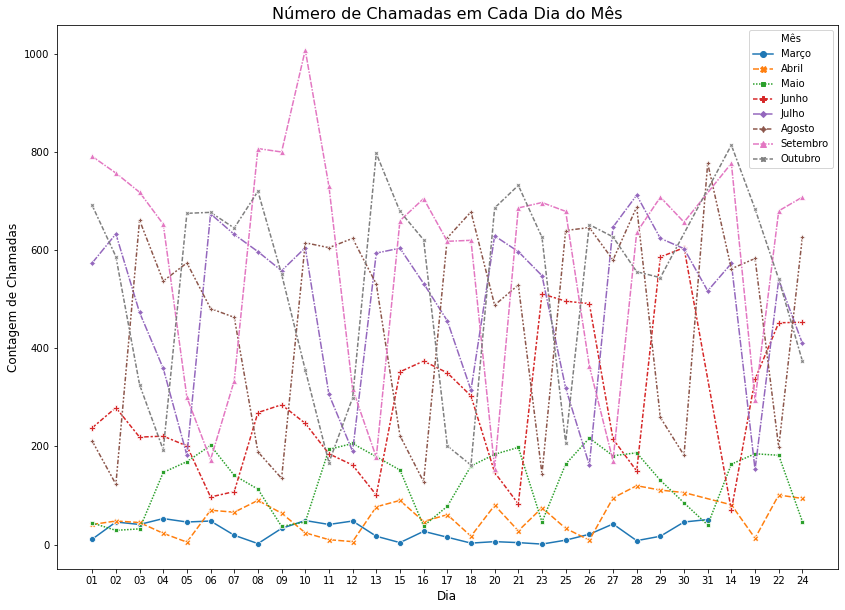

In [52]:
# Verificando se é possível observar uma relação do número de chamadas de acordo com o dia da semana 

# https://seaborn.pydata.org/generated/seaborn.lineplot.html
plt.figure(figsize=(14,10))

sns.lineplot(data = grafico1, x = 'dia', y = 'count', hue = 'Mês', style = 'Mês', markers = True)
plt.title('Número de Chamadas em Cada Dia do Mês', fontdict={'fontsize':16})
plt.xlabel('Dia', fontdict = {'fontsize': 12})
plt.ylabel('Contagem de Chamadas', fontdict = {'fontsize': 12})
plt.show()



> Não é possível notar um padrão no número de chamadas com base no dia da semana

In [53]:
# Verificar o Número de chamadas por Mês
grafico12 = q1.groupby(['Mês'], sort=False).agg({'id':'count'}).reset_index(drop = False)
grafico12 = grafico12.rename(columns= {'id':'count'})
grafico12

,Mês,count
0,Fevereiro,91
1,Março,708
2,Abril,1730
3,Maio,3978
4,Junho,8587
5,Julho,15318
6,Agosto,14305
7,Setembro,17381
8,Outubro,15391


> Podemos desconsiderar o mês de Fevereiro das Análises pois os registros começam ao final do mês. 

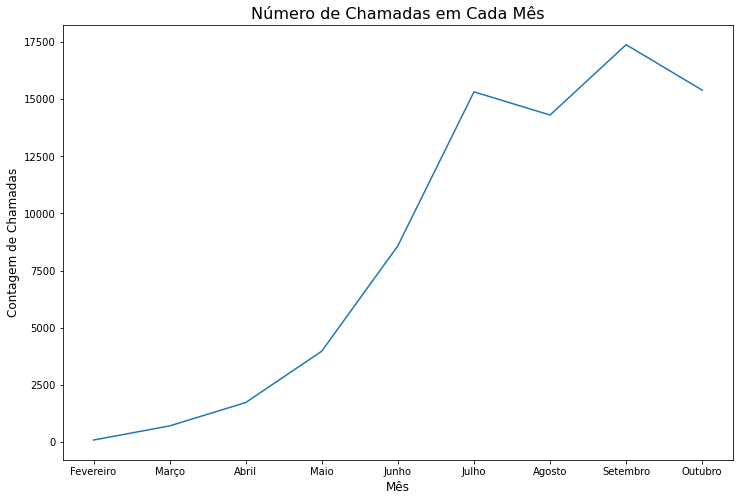

In [54]:

# Line plot -> Pode ser que apagar esse gráfico seja melhor
plt.figure(figsize=(12,8))

sns.lineplot(data = grafico12, x = 'Mês', y = 'count', markers = 'O')
plt.title('Número de Chamadas em Cada Mês', fontdict={'fontsize':16})
plt.xlabel('Mês', fontdict = {'fontsize': 12})
plt.ylabel('Contagem de Chamadas', fontdict = {'fontsize': 12})
plt.show()
plt.show()

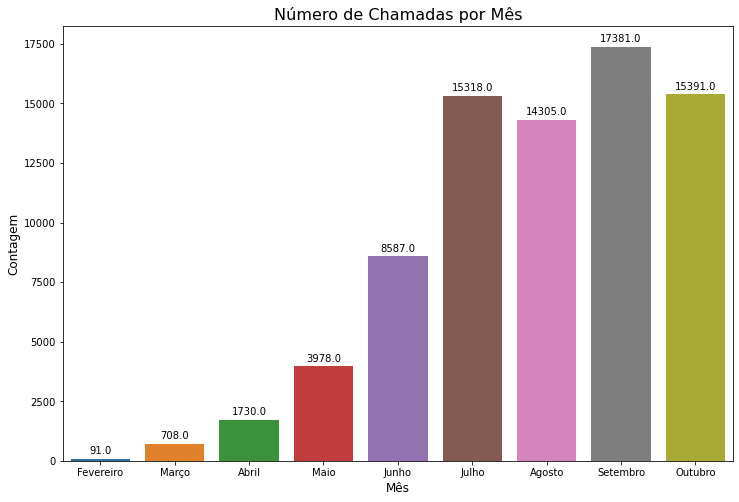

In [55]:
# Gráfico de barras que representa a quantidade de chamadas por Mês 
plt.figure(figsize=(12,8))

ax = sns.barplot(data = grafico12, x = 'Mês', y = 'count')
plt.title('Número de Chamadas por Mês', fontdict={'fontsize':16})
plt.xlabel('Mês', fontdict = {'fontsize': 12})
plt.ylabel('Contagem', fontdict = {'fontsize': 12})

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+ 200, round(p.get_height(), 2), horizontalalignment='center')
    
plt.show()

In [56]:
grafico13 = grafico12.copy()
grafico13['mudanca'] = np.where((grafico13['Mês'] == 'Agosto') | (grafico13['Mês'] == 'Setembro') | (grafico13['Mês'] == 'Outubro'),'Pos Mudanca', 'Pre Mudanca')
grafico13

,Mês,count,mudanca
0,Fevereiro,91,Pre Mudanca
1,Março,708,Pre Mudanca
2,Abril,1730,Pre Mudanca
3,Maio,3978,Pre Mudanca
4,Junho,8587,Pre Mudanca
5,Julho,15318,Pre Mudanca
6,Agosto,14305,Pos Mudanca
7,Setembro,17381,Pos Mudanca
8,Outubro,15391,Pos Mudanca


In [57]:
# Vamos remover a linha referente a Fevereiro por ser um valor muito abaixo (há registro somente do final do mês em Fevereiro)
grafico13.drop(0, axis= 0, inplace= True)
grafico13

,Mês,count,mudanca
1,Março,708,Pre Mudanca
2,Abril,1730,Pre Mudanca
3,Maio,3978,Pre Mudanca
4,Junho,8587,Pre Mudanca
5,Julho,15318,Pre Mudanca
6,Agosto,14305,Pos Mudanca
7,Setembro,17381,Pos Mudanca
8,Outubro,15391,Pos Mudanca


In [58]:
grafico13 = grafico13.groupby('mudanca').agg({'count':'mean'}).reset_index(drop = False)
grafico13.columns = ['Mudanca', 'Media']
grafico13

,Mudanca,Media
0,Pos Mudanca,15692.333333
1,Pre Mudanca,6064.200000


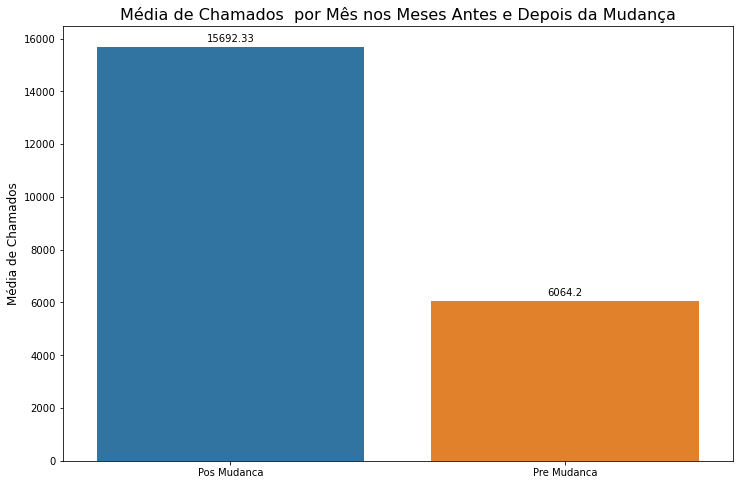

In [59]:
# Gráfico que mostra a média de chamadas antes e pós a mudança
plt.figure(figsize=(12,8))

ax = sns.barplot(x = grafico13['Mudanca'] , y = grafico13['Media'])
plt.title('Média de Chamados  por Mês nos Meses Antes e Depois da Mudança', fontdict={'fontsize':16})
plt.xlabel('')
plt.ylabel('Média de Chamados', fontdict = {'fontsize': 12})

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+ 200, round(p.get_height(), 2), horizontalalignment='center')
    
plt.show()

> A mundaça nãa parece ter surtido efeito, visto que o número de chamadas mensal aumentou após as mudanças feitas.  
> No entanto, apesar de improvável devido ao pequeno intervalo de tempo, esse alto número de chamadas pode ter sido causada por um aumento no número de clientes.

In [60]:
df2.head()

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
0,2019-07-24,Betim,MG,T1,0011L00002Wd777QAB
1,2019-07-24,Mossoró,RN,T1,0011L00002Wd78eQAB
2,2019-07-24,Rio de Janeiro,RJ,T1,0011L00002WdAxkQAF
3,2019-07-24,Maricá,RJ,NONE,0011L00002Wd7AkQAJ
4,2019-07-24,São Paulo,SP,T1,0011L00002Wd78PQAR


In [61]:
q1 = df2.copy()
q1.drop_duplicates('id_conta', inplace = True)
q1

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
0,2019-07-24,Betim,MG,T1,0011L00002Wd777QAB
1,2019-07-24,Mossoró,RN,T1,0011L00002Wd78eQAB
2,2019-07-24,Rio de Janeiro,RJ,T1,0011L00002WdAxkQAF
3,2019-07-24,Maricá,RJ,NONE,0011L00002Wd7AkQAJ
4,2019-07-24,São Paulo,SP,T1,0011L00002Wd78PQAR
...,...,...,...,...,...
77476,2020-10-30,Embu-Guaçu,SP,T1,0013j000030FWnRAAW
77482,2020-10-30,Goiânia,GO,T2,0013j000030EO1KAAW
77483,2020-10-30,Rio de Janeiro,RJ,T1,0013j000030FZxaAAG
77485,2020-10-30,Placas,PA,T3,0013j000030SNX6AAO


In [62]:
apos_agosto = q1[(q1['data_cred'] > "2020-08-01")]
apos_agosto

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
47759,2020-08-02,Serra,ES,T3,0013j00002z1HU9AAM
47760,2020-08-02,São Lourenço da Mata,PE,T3,0013j00002z1HW5AAM
47761,2020-08-02,São Paulo,SP,T3,0013j00002z1GQzAAM
47762,2020-08-02,Fortaleza,CE,T2,0013j00002z1GuLAAU
47763,2020-08-02,Blumenau,SC,T3,0013j00002z1HAEAA2
...,...,...,...,...,...
77476,2020-10-30,Embu-Guaçu,SP,T1,0013j000030FWnRAAW
77482,2020-10-30,Goiânia,GO,T2,0013j000030EO1KAAW
77483,2020-10-30,Rio de Janeiro,RJ,T1,0013j000030FZxaAAG
77485,2020-10-30,Placas,PA,T3,0013j000030SNX6AAO


In [63]:
entre_marco_agosto = q1[(q1['data_cred'] < "2020-08-01") & (q1['data_cred'] > "2020-03-01")]
entre_marco_agosto

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
4152,2020-03-02,Silveira Martins,RS,T1,0011L00002ebJPxQAM
4153,2020-03-02,São Gonçalo,RJ,T3,0011L00002deKPZQA2
4154,2020-03-02,Rio de Janeiro,RJ,T1,0011L00002ebJObQAM
4157,2020-03-02,Campina Grande,PB,T3,0011L00002ebL2lQAE
4158,2020-03-02,Indaial,SC,T3,0011L00002ebD3CQAU
...,...,...,...,...,...
47458,2020-07-31,Louveira,SP,T3,0013j00002z0wpqAAA
47460,2020-07-31,Vila Velha,ES,T3,0013j00002z0nq5AAA
47461,2020-07-31,São Paulo,SP,T2,0013j00002z15kiAAA
47463,2020-07-31,Manaus,AM,T2,0013j00002z0hTAAAY


In [64]:
print(f'Média de contas credenciadas criadas por mês nos meses entre Março e Agosto {len(entre_marco_agosto)/5}')
print(f'Média de contas credenciadas por mês nos meses entre Agosto e Outubro {len(apos_agosto)/3}')

Média de contas credenciadas criadas por mês nos meses entre Março e Agosto 3130.0
Média de contas credenciadas por mês nos meses entre Agosto e Outubro 4649.0


In [65]:
print(f'Aumento percentual no número de credenciamento mensal dos Meses de Março-Julho para Agosto-Outubro: {round((len(entre_marco_agosto)/5)/(len(apos_agosto)/3)*100,2)}%')

Aumento percentual no número de credenciamento mensal dos Meses de Março-Julho para Agosto-Outubro: 67.33%


In [66]:
print(f'Aumento percentual no número de chamadas mensal dos Meses de Março-Julho para Agosto-Outubro: {round((grafico13.Media[1]) / (grafico13.Media[0]) * 100, 2)}%')

Aumento percentual no número de chamadas mensal dos Meses de Março-Julho para Agosto-Outubro: 38.64%


> Houve um aumento de aproximadamente 67.3% no número de credenciamentos por mês nos meses após Agosto.  
> Se compararmos o número de chamadas dos meses de Agosto a Outubro com o número de chamadas de Março a Julho tivemos um aumento de aproximadamente 39.6%. Portanto, por este prisma, pode-se dizer que houve uma diminuição no número de chamadas, pois teríamos que ter um aumento no número de chamadas similar ao aumento no número de contas credenciadas para dizer que não havia nem aumentado, nem diminuído.  
> Obs: Esta afirmação parte da hipótese de que todos os registros credenciamentos estão contidos na tabela df2

# Questão 2

2.	Foi notado pelo nosso time que clientes recem credenciados possuem um comportamento específico em relação à quantidade de chamados realizados logo após seu credenciamento. Identifique e prepare alguma forma de visualizar essa diferença notada pelos agentes.

Irei comparar apenas os registros que tem chamadas após o credenciamento

> Duas maneiras de visualizar: ver o numero de chamadas ao longo do tempo(após o credenciamento).  
> Contagem do número de chamadas  após o credenciamento. Tentarei fazer com essa segunda opção. (Terei que comparar com o número de chamadas após o primeiro mês)

In [70]:
df

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
0,0011L00002ZbpnlQAB,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:
2,0011L00002WdgbcQAB,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...
3,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido
4,0011L00002We7cjQAB,2020-02-26,Telefone,72.0,False,Enviado,Aplicativo::
...,...,...,...,...,...,...,...
77484,0013j00002ymhaoAAA,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Prazos ...
77485,0013j00002ynvv0AAA,2020-10-29,Telefone,8.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Renda E...
77486,0013j00002zfqezAAA,2020-10-29,Telefone,10.0,False,Sem_resposta,Aplicativo:Cartões:Ativação
77487,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS


In [69]:
df2

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
0,2019-07-24,Betim,MG,T1,0011L00002Wd777QAB
1,2019-07-24,Mossoró,RN,T1,0011L00002Wd78eQAB
2,2019-07-24,Rio de Janeiro,RJ,T1,0011L00002WdAxkQAF
3,2019-07-24,Maricá,RJ,NONE,0011L00002Wd7AkQAJ
4,2019-07-24,São Paulo,SP,T1,0011L00002Wd78PQAR
...,...,...,...,...,...
77484,2020-10-30,Rio de Janeiro,RJ,T1,0013j000030FZxaAAG
77485,2020-10-30,Placas,PA,T3,0013j000030SNX6AAO
77486,2020-10-30,Rio de Janeiro,RJ,T1,0013j000030FZxaAAG
77487,2020-10-30,Almirante Tamandaré,PR,T2,0013j00002yLMR1AAO


In [71]:
df3 = pd.merge(df, df2[[ 'id_conta', 'data_cred', 'produto_adquirido']], left_on = 'id', right_on= 'id_conta', how = 'left')
df3

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id_conta,data_cred,produto_adquirido
0,0011L00002ZbpnlQAB,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos,0011L00002ZbpnlQAB,2019-10-28,T1
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,2020-02-12,T3
2,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,2020-02-12,T3
3,0011L00002WdgbcQAB,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...,0011L00002WdgbcQAB,2019-07-28,NONE
4,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido,0011L00002WdJgjQAF,2019-07-25,T1
...,...,...,...,...,...,...,...,...,...,...
326950,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3
326951,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3
326952,0013j00002zeAEbAAM,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Transfe...,0013j00002zeAEbAAM,2020-09-02,T3
326953,0013j00002zeAEbAAM,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Transfe...,0013j00002zeAEbAAM,2020-09-02,T3


In [73]:
# Verificando se está gerando valores duplicados (devido aos pedidos de mais de uma máquininha para uma loja)
df3[(df3.duplicated() == True)]

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id_conta,data_cred,produto_adquirido
2,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,2020-02-12,T3
5,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido,0011L00002WdJgjQAF,2019-07-25,T1
8,0011L00002cptcAQAQ,2020-02-26,Telefone,12.0,False,Sem_resposta,Transferência de saldo:Conta bancária:Problema,0011L00002cptcAQAQ,2020-01-29,T1
9,0011L00002cptcAQAQ,2020-02-26,Telefone,12.0,False,Sem_resposta,Transferência de saldo:Conta bancária:Problema,0011L00002cptcAQAQ,2020-01-29,T1
10,0011L00002cptcAQAQ,2020-02-26,Telefone,12.0,False,Sem_resposta,Transferência de saldo:Conta bancária:Problema,0011L00002cptcAQAQ,2020-01-29,T1
...,...,...,...,...,...,...,...,...,...,...
326949,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3
326950,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3
326951,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3
326953,0013j00002zeAEbAAM,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Transfe...,0013j00002zeAEbAAM,2020-09-02,T3


In [74]:
# Irei remover esses registros pois não estamos interessados no momento na informação de quantas máquininhas um cliente pediu
df3 = df3[(df3.duplicated() == False)]
df3

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id_conta,data_cred,produto_adquirido
0,0011L00002ZbpnlQAB,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos,0011L00002ZbpnlQAB,2019-10-28,T1
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,2020-02-12,T3
3,0011L00002WdgbcQAB,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...,0011L00002WdgbcQAB,2019-07-28,NONE
4,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido,0011L00002WdJgjQAF,2019-07-25,T1
6,0011L00002We7cjQAB,2020-02-26,Telefone,72.0,False,Enviado,Aplicativo::,0011L00002We7cjQAB,2019-08-03,NONE
...,...,...,...,...,...,...,...,...,...,...
326938,0013j00002ymhaoAAA,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Prazos ...,0013j00002ymhaoAAA,2020-06-30,T2
326943,0013j00002ynvv0AAA,2020-10-29,Telefone,8.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Renda E...,0013j00002ynvv0AAA,2020-07-07,T2
326944,0013j00002zfqezAAA,2020-10-29,Telefone,10.0,False,Sem_resposta,Aplicativo:Cartões:Ativação,0013j00002zfqezAAA,2020-09-15,T2
326946,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3


In [75]:
# Filtrar as chamadas que ocorrem em ATÉ UM(podemos mudar pra testar) mês após a data do credenciamento do cliente
q2 = df3[(df3['data'] - df3['data_cred'] < np.timedelta64(1,'M'))]
q2

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id_conta,data_cred,produto_adquirido
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,2020-02-12,T3
7,0011L00002cptcAQAQ,2020-02-26,Telefone,12.0,False,Sem_resposta,Transferência de saldo:Conta bancária:Problema,0011L00002cptcAQAQ,2020-01-29,T1
11,0011L00002cptcAQAQ,2020-02-26,Telefone,12.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Saldo,0011L00002cptcAQAQ,2020-01-29,T1
15,0011L00002dcq90QAA,2020-02-26,Telefone,13.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Transfe...,0011L00002dcq90QAA,2020-02-19,T1
31,0011L00002dcYFoQAM,2020-02-26,Telefone,10.0,False,Sem_resposta,Produto:Pinpad:Dúvidas pinpad,0011L00002dcYFoQAM,2020-02-18,T1
...,...,...,...,...,...,...,...,...,...,...
326911,0013j000030D9XtAAK,2020-10-29,Telefone,19.0,False,Sem_resposta,Logística:OS:Ineficiência,0013j000030D9XtAAK,2020-10-20,T1
326924,0013j000030CP9BAAW,2020-10-29,Telefone,12.0,False,Sem_resposta,Logística:Envio Chip:,0013j000030CP9BAAW,2020-10-14,T2
326935,0013j000030DBflAAG,2020-10-29,Telefone,13.0,False,Sem_resposta,Logística:OS:Ineficiência,0013j000030DBflAAG,2020-10-21,T1
326936,0013j000030EFnAAAW,2020-10-29,Telefone,7.0,False,Sem_resposta,Pedido:Cancelamento:Outros,0013j000030EFnAAAW,2020-10-24,T3


In [ ]:
# Talvez seja melhor criar uma coluna binária que indique se a chamada foi feita antes ou dps de um mês de credenciamento (1 -> chamadas de clientes recém credenciados , 0 -> chamados de clientes credenciados a mais de 1 mês)
# df3['chamadas_primeiro_mes'] = np.where((df3['data'] - df3['data_cred'] < np.timedelta64(1, 'M')), 1, 0)

In [ ]:
# Estou Criando uma nova coluna 'chamadas_primeiro_mes' para identificar se a chamada for feita logo após o credenciamento do cliente ou não
df3['chamadas_primeiro_mes'] = np.where((df3['data'] < df3['data_cred']), 'Chamadada Sem Credenciamento',
                                np.where((df3['data'] - df3['data_cred'] < np.timedelta64(1, 'M')), 'Chamada Com Menos de 1 Mês de Credenciamento' ,
                                np.where((df3['data'] - df3['data_cred'] > np.timedelta64(1, 'M')), 'Chamada Com Mais de 1 Mês de Credenciamento', np.nan)))

df3.chamadas_primeiro_mes.value_counts()

In [ ]:
# Aqui já podemos ver que as chamadas do primeiro mês representam mais da metade do restante das chamadas
df3.groupby(['chamadas_primeiro_mes']).agg({'id': 'count'})

In [76]:
df[(df['id'] == '0013j000030FZxaAAG')]

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
77173,0013j000030FZxaAAG,2020-10-29,Telefone,7.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Primeir...
77174,0013j000030FZxaAAG,2020-10-29,Telefone,7.0,False,Sem_resposta,Pedido:Confirmação do pedido:
77175,0013j000030FZxaAAG,2020-10-29,Telefone,7.0,False,Sem_resposta,Produto:Modelo de recebimento:


In [ ]:
df2['produto_adquirido'].value_counts()

In [ ]:
df2[(df2.id_conta == '0011L00002Y3mjiQAB')]

Nas linhas acima, é possível notar que há chamadas do id "0011L00002Y3mjiQAB" antes da data de credenciamento. Porém isso não faz sentido, uma vez que o cliente precisa ser credenciado para começar a fazer chamadas

In [ ]:
# Existem 3768 linhas em que os clientes possuem chamadas antes de terem sidos credenciados.
df4 = df3[(df3['data'] > df3['data_cred'])]
df4

In [ ]:
df4.assunto.value_counts()

In [ ]:
df4.groupby(['chamadas_primeiro_mes']).agg({'id': 'count'})


# Questão 3

3.	Para conseguir melhorar a qualidade do nosso atendimento ao cliente, foi proposto que a alguns chamados tenham prioridade de atendimento. Levando em consideração o motivo dos chamados, como você estabeleceria essa prioridade da fila de espera? Sugestão: Proponha uma clusterização da base de clientes que julgue atender da melhor forma a necessidade apresentada.

# Questão 4

4.	Escreva duas queries em SQL que retornem: 

i) o volume de chamados por semana dos últimos três meses para cada cluster de clientes proposto na questão 3.

ii) uma série histórica dia a dia, que para cada dia retorne o número de chamados referentes aos últimos 30 dias (por exemplo, para o dia 30/01, a query deve retornar a quantidade de chamados totais entre os dias 01/01 e 30/01)


# Questão 5

5.	Questão de estudo livre: Como é esperado de um analista de dados, traga insights relevantes sobre pontos de atenção e possíveis melhorias que você identificou ao analisar ambas as bases de dados. Além disso faça pelo menos duas perguntas relacionadas aos dados que julgue relevantes para análise, você também pode sugerir outros dados para enriquecer os aqui disponibilizados.